# Investigating the frequency and battery charge

We start by importing libaries that should have been installed when installing the package

The `dynamic_containment` module is part of this package

In [1]:
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import special
import openturns as ot
from scipy.optimize import least_squares
import warnings
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

from dynamic_containment import utils

plt.rcParams['text.usetex'] = False

## Create the battery charge model

We have set up a function within `dynamic_containment` to calculate the charge associated with each change in frequency

Text(0, 0.5, 'Charge %')

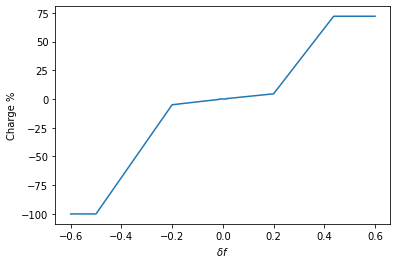

In [2]:
df = np.linspace(-0.6, 0.6, num=1000)

plt.plot(df, [100*utils.battery_power(dfi, 5) for dfi in df])
plt.xlabel("$\delta f$")
plt.ylabel("Charge %")

## Read in the data

Here we read in the data and make some small changes to filenames etc

In [3]:
freq_table = utils.read_and_clean()

Let's look a the frequency. Throughout the notebook I used $\delta f=$ frequency - 50

<AxesSubplot:xlabel='date'>

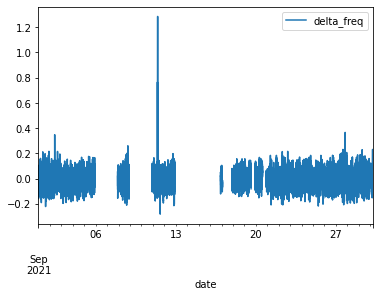

In [4]:
freq_table.plot("date", "delta_freq")

As a starting point let's exctract teh continuous region

In [5]:
service_power = 5

In [6]:
max_missing = freq_table[freq_table.isnull().any(axis=1)].date.max()

In [7]:
start = max_missing.date() + timedelta(days=1)

In [8]:
end = freq_table.date.max().date()

In [9]:
cont_table = utils.extract_time_block(start, end, freq_table)

In [10]:
cont_table.head()

,date,freq,delta_freq
1728000,2021-09-21 00:00:00,50.053,0.053
1728001,2021-09-21 00:00:01,50.048,0.048
1728002,2021-09-21 00:00:02,50.042,0.042
1728003,2021-09-21 00:00:03,50.035,0.035
1728004,2021-09-21 00:00:04,50.030,0.030


Let's look at a histogram of the frequencies

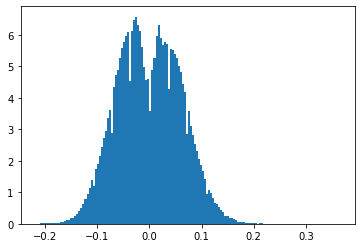

In [11]:
hist = plt.hist(cont_table.delta_freq, bins=150, density=True)

It's looks pretty symmetric, but it seems to have two Peaks. Let's see how well a Normal distribution fits

In [12]:
bin_cents = 0.5*(hist[1][1:] + hist[1][:-1])

In [13]:
f = least_squares(utils.hist_fit_gauss, x0 = [0.0, 0.04], args=(bin_cents, hist[0]))

In [14]:
gauss = utils.normal_dist(bin_cents, f.x[1], mu=f.x[0])
gauss = gauss / np.trapz(gauss, bin_cents)

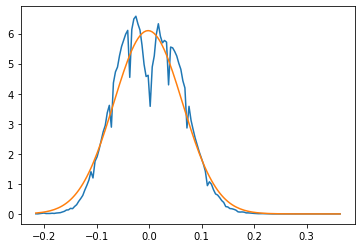

In [15]:
plt.plot(bin_cents, hist[0])
plt.plot(bin_cents, gauss)

Not too bad, but not perfect. We will start by assuming it is Normal, but come back to this.

We can calculate the the charge, assuming we have a full battery to begin with, for simplicity, ignoring going battery capacity for now.

In [16]:
cont_table = utils.add_charge_info(cont_table, service_power)

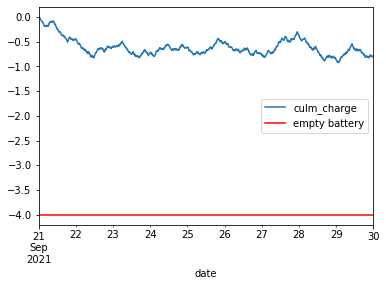

In [17]:
cont_table.plot('date', 'culm_charge')
plt.axhline(-4.0, color='red', label="empty battery")
plt.legend()

# Creating mock data for better stats

Now let's try and generate more data using Gaussian simulations. I will start by trying using the spectral density of $\delta f$. To do this, I am using the `openturns` package

In [18]:
process = utils.simulate_delta_f(cont_table)

In [19]:
# draw a sample
sample = process.getSample(1)

WRN - Warning! The cache for cholesky factors is full. Expect a big performance penalty. Increase the cache size using the ResourceMap key "SpectralGaussianProcess-CholeskyCacheSize" if you have enough memory.


In [20]:
vals = [sample[0][i][0] for i in range(len(sample[0]))]

There is a scaling problem that I need to look into, but we can sidestep this for now by scaling the variance.

In [21]:
vals = np.array(vals) * freq_table.delta_freq.std() / np.std(vals)

Now we have the correct standard deviation.

In [22]:
freq_table.delta_freq.std()

0.059980953240247284

In [23]:
vals.std()

0.0599809532402473

We can process the simulated data now

In [24]:
df_sim = pd.DataFrame()
df_sim['date'] = range(len(vals))
df_sim['delta_freq'] = vals

In [25]:
df_sim = utils.add_charge_info(df_sim, service_power)

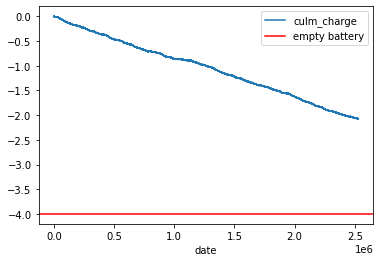

In [26]:
df_sim.plot('date', 'culm_charge')
plt.axhline(-4.0, color='red', label="empty battery")
plt.legend()

Let's just look at the behaviour of the frequencies at smaller scales. Say, 1 hour

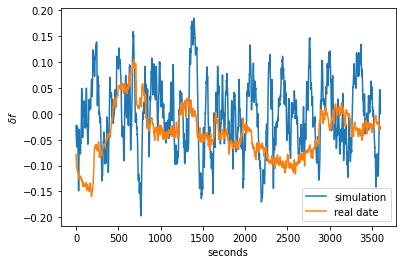

In [27]:
plt.plot(df_sim.iloc[:3600]["date"], df_sim.iloc[:3600]["delta_freq"], label="simulation")
plt.plot(df_sim.iloc[:3600]["date"], freq_table.iloc[:3600]["delta_freq"], label="real date")
plt.xlabel("seconds")
plt.ylabel("$\delta f$")
plt.legend()

Interesting, it doesn't look right. We are missing large scale correlations, perhaps due to cutting the data, as we are masked by missing data, so we would need to account for this using the spectral density. Let's see how we get on using a two-point correlation function instead. We sample the covariance and interpolate for speed.

In [28]:
real_space_cov = utils.temporal_covariance(freq_table, max_sep=18001, step=50)

  0%|          | 0/361 [00:00<?, ?it/s]

Text(0, 0.5, 'Covariance')

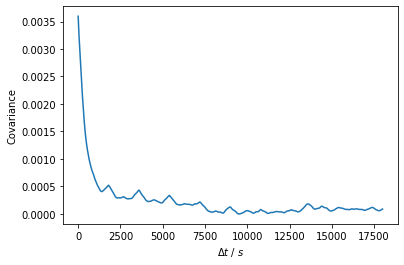

In [29]:
plt.plot(real_space_cov.keys(), real_space_cov.values())
plt.xlabel("$\Delta t$ / $s$")
plt.ylabel("Covariance")

Now we can generate mock Gaussian sims using this covariance.

To make the simulations faster, I have created samples at time steps of 10 and interpolated. This will increase small-scale correlations, but I think it is the large-scale correlations that are potentially the most problematic. I also produce the simulations in ten-hour blocks. Looking at the real data above, one hour seems to capture the big fluctations in frequency, so ten hours should be safe.

In [30]:
# first makes sure I generate enough data (18000s = 5hrs)

num_blocks = np.ceil(len(freq_table.delta_freq) / (18000.0))

# This is the number of realisations. I have tested at higher values, but takes longer to run
nreals = 25

time_step = 10
num_samples = [nreals, int(num_blocks)]

In [31]:
samples = utils.simulate_grf_using_cov(real_space_cov, max_time=18000, time_step=time_step, num_samples=num_samples)

creating covariance
creating samples


In [32]:
np.shape(samples)

(25, 141, 1800)

I am going to create simulations of the same length as the real data

In [33]:
samples = [s.flatten()[:len(freq_table)] for s in samples]

In [34]:
new_samples = utils.interp_samples(samples, max_time=len(freq_table), step_samples=10)

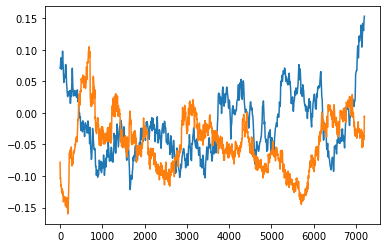

In [35]:
plt.plot(new_samples[0][:7200])
plt.plot(
    freq_table.delta_freq.iloc[:7200]
)

This looks a lot better!

One thing we can do now is look at the dispersion of the mean $\delta f$, and use this information to see if there is evidence of a bias in our real data

In [36]:
means = np.mean(new_samples, axis=1)

In [37]:
print(f"Standard deviation on the mean is {means.std()}")

Standard deviation on the mean is 0.0014836465728495373


In [38]:
print(f"The mean of the real data is {np.mean(freq_table.delta_freq)}")

The mean of the real data is 0.001010777745241588


So the real data sees no evidence of a bias in the frequency.

Bare in mind that we also have missing data in the real table, so the actual disperion we should probably look at is 

In [39]:
means.std() * np.sqrt(len(freq_table)/len(freq_table.dropna()))

0.0018053624442348328

Let's now process all of our realisations to give us a suite of mock charge losses.

This takes a few mins!

In [40]:
reals = {}

count = 0

for s in tqdm(new_samples):
    
    df = pd.DataFrame()
    df["date"] = range(len(s))
    df["delta_freq"] = s
    df = utils.add_charge_info(df, service_power)
    
    reals[count] = df
    
    count+=1
    

  0%|          | 0/25 [00:00<?, ?it/s]

And calculate some basic summary stats

In [41]:
df_mean = reals[0].copy()
df_mean['culm_charge'] = 0.0
df_mean['culm_charge_sq'] = 0.0

for s in reals:
    
    df_mean['culm_charge'] += reals[s]['culm_charge']
    df_mean['culm_charge_sq'] += reals[s]['culm_charge']**2.0
    


In [42]:
df_mean['culm_charge'] = df_mean['culm_charge'] / len(reals)

In [43]:
df_mean['var_charge'] = (
    df_mean['culm_charge_sq'] / (len(reals) - 1)
    - df_mean['culm_charge']**2.0 * len(reals) / (len(reals) - 1)
)

In [44]:
df_mean['std_charge'] = np.sqrt(df_mean['var_charge'])

I will also use the simulation to fill in my missing data

In [45]:
freq_table = utils.fill_in_spectra(freq_table, reals[1])

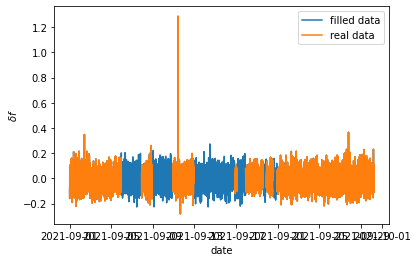

In [46]:
plt.plot(freq_table['date'], freq_table['filled_delta_freq'], label='filled data')
plt.plot(freq_table['date'], freq_table['delta_freq'], label='real data')
plt.xlabel('date')
plt.ylabel('$\delta f$')
plt.legend()

As a comparison, I will also make some pure noise simulations.

In [47]:
gauss_noise = np.random.normal(0.0, freq_table['filled_delta_freq'].std(), size=len(freq_table))

In [48]:
df_white_noise = pd.DataFrame()
df_white_noise['date'] = range(len(freq_table))
df_white_noise['delta_freq'] = gauss_noise

In [49]:
df_white_noise = utils.add_charge_info(df_white_noise, service_power)

calculate the charge info for the filled in data

In [50]:
df_filled = utils.add_charge_info(
    freq_table.drop('delta_freq', axis=1).rename({'filled_delta_freq': 'delta_freq'}, axis=1),
    service_power
)

Now let's plot the lot! Including a single simulated realisation

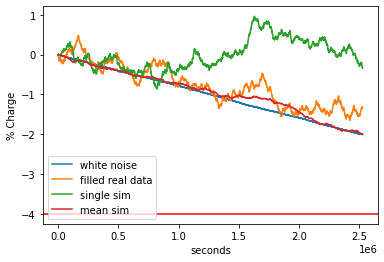

In [51]:
plt.plot(df_white_noise.date, df_white_noise.culm_charge, label="white noise")
plt.plot(df_white_noise.date, df_filled.culm_charge, label="filled real data")
plt.plot(df_white_noise.date, reals[2].culm_charge, label="single sim")
plt.plot(df_white_noise.date, df_mean.culm_charge, label="mean sim")
plt.axhline(-4.0, color='red')
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

This looks good! Be aware, the the single realisations fluctuate! And that includes the real data!

## Calculating the change in change

Now let's have some fun. Assuming Gaussian distributed white noise data, we can calculate the average rate of change of charge in the battery.

In [52]:
c = utils.calc_gaussian_slope(freq_table.delta_freq.std(), service_power)

In [53]:
theory_charge = c * np.arange(len(df_white_noise))

In [54]:
sample_points = np.linspace(0, len(df_white_noise)-1, num=50)
sample_points = [int(np.round(sample_points[i])) for i in range(len(sample_points))]

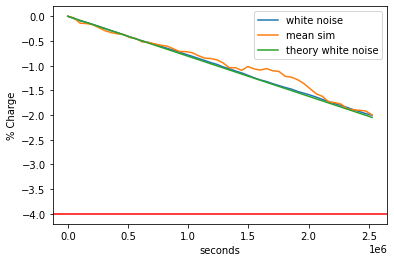

In [55]:
plt.plot(
    df_white_noise.iloc[sample_points].date,
    df_white_noise.iloc[sample_points].culm_charge,
    label="white noise"
)
plt.plot(
    df_white_noise.iloc[sample_points].date,
    df_mean.iloc[sample_points].culm_charge,
    label="mean sim"
)
plt.plot(
    df_white_noise.iloc[sample_points].date,
    theory_charge[sample_points],
    label="theory white noise"
)
plt.axhline(-4.0, color='red')
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

Great, now we know what the averege rate of change of charge is, assuming white noise data

In [56]:
print(f"It is dC/dt = {c*3600} MW")

It is dC/dt = -0.002915229935260698 MW


We can also do the same using a histogram of the real data

In [57]:
c_hist = utils.calc_data_slope(freq_table.dropna(), service_power, bins=34)

In [58]:
theory_charge_hist = c_hist * np.arange(len(df_white_noise))

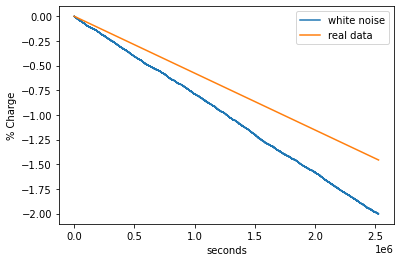

In [59]:
plt.plot(df_white_noise.date, df_white_noise.culm_charge, label="white noise")
plt.plot(df_white_noise.date, theory_charge_hist, label="real data")
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

This doesn't match the simulation, but is very susceptible to the bin size. Looking back, we had the frequency histogram

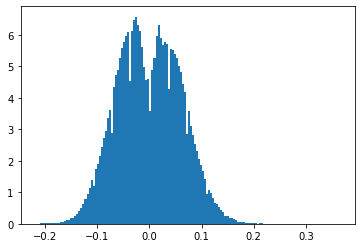

In [60]:
hist = plt.hist(cont_table.delta_freq, bins=150, density=True)

Which is double Peaked. This double Peak may cause an issue, since this pushes frequecies outside the deadband. Let's fit a double Normal distribution and see what happens. We can use this to calculate $dC / dt$ without worrying too much about binned finite data

In [61]:
bin_cents = 0.5*(hist[1][1:] + hist[1][:-1])

In [62]:
f = least_squares(utils.hist_fit_2gauss, x0 = [0.04, 0.04], args=(bin_cents, hist[0]))

In [63]:
gauss1 = utils.normal_dist(bin_cents, f.x[1], mu=-f.x[0])
gauss2 = utils.normal_dist(bin_cents, f.x[1], mu=f.x[0])

In [64]:
double_gauss = np.where(bin_cents<0, gauss1, gauss2)
double_gauss = double_gauss / np.trapz(double_gauss, bin_cents)

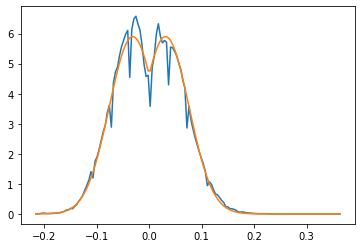

In [65]:
plt.plot(bin_cents, hist[0])
plt.plot(bin_cents, double_gauss)

That looks a bit better than a single Normal distribution. Let's try simulating it

In [66]:
samples = utils.generate_sample_df(double_gauss, bin_cents, num_samps=len(freq_table))

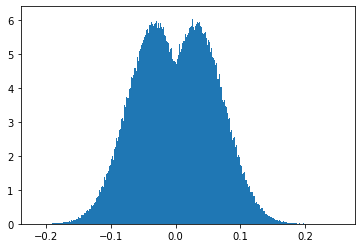

In [67]:
hist_samp = plt.hist(samples, density=True, bins=1000)

In [68]:
samples.std()

0.05950482793704663

Almost feels like a stroke of luck, but we appear to have a good match for the disperion!

In [69]:
sample_df = pd.DataFrame()
sample_df["date"] = range(len(samples))
sample_df["delta_freq"] = samples

In [70]:
sample_df = utils.add_charge_info(sample_df, service_power)

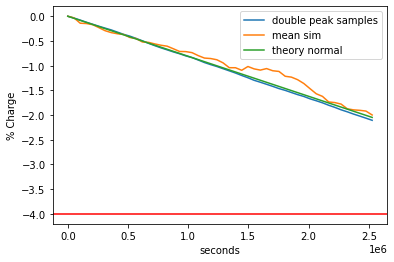

In [71]:
plt.plot(
    sample_df.iloc[sample_points].date, sample_df.iloc[sample_points].culm_charge, label='double peak samples'
)
plt.plot(
    df_white_noise.iloc[sample_points].date, df_mean.iloc[sample_points].culm_charge, label="mean sim"
)
plt.plot(
    df_white_noise.iloc[sample_points].date, theory_charge[sample_points], label="theory normal"
)
plt.axhline(-4.0, color='red')
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

In [72]:
fitted_c = utils.calc_fitted_slope(double_gauss, bin_cents, service_power)

In [73]:
theory_charge_hist = fitted_c * np.arange(len(df_white_noise))

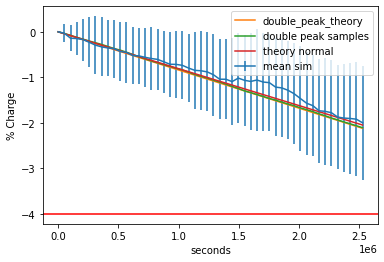

In [74]:
plt.errorbar(
    df_white_noise.iloc[sample_points].date,
    df_mean.iloc[sample_points].culm_charge,
    df_mean.iloc[sample_points].std_charge,
    label="mean sim"
)
plt.plot(
    df_white_noise.iloc[sample_points].date,
    theory_charge_hist[sample_points],
    label='double_peak_theory'
)
plt.plot(
    sample_df.iloc[sample_points].date,
    sample_df.iloc[sample_points].culm_charge,
    label='double peak samples'
)
#plt.plot(df_white_noise.date, df_mean.culm_charge, label="mean sim")
plt.plot(
    df_white_noise.iloc[sample_points].date,
    theory_charge[sample_points],
    label="theory normal"
)
plt.axhline(-4.0, color='red')
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

He, we have overplotted the dispersion in the simulations as well. We see a large uncertainty that increases with time. Also, we see that the double peak and single white noise agree well, as so the mean simulations.

With this in mind, will use the the theory white noise going forward, but we can analyse the uncertainties using the simulations.

The main part of the analysis follows in the `Analysing the models` notebook